<a href="https://colab.research.google.com/github/MosinInamdar/MachineLearning/blob/main/StockPredictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import yfinance as yf

In [2]:
# Step 1: Data Collection
def fetch_stock_data(ticker, start_date, end_date):
    """
    Fetch historical stock data using Yahoo Finance API.
    """
    data = yf.download(ticker, start=start_date, end=end_date)
    return data

# Example: Fetch Nifty 50 data
ticker = '^NSEI'  # Nifty 50 index
start_date = '2010-01-01'
end_date = '2024-12-01'
stock_data = fetch_stock_data(ticker, start_date, end_date)


[*********************100%***********************]  1 of 1 completed


In [3]:
# Step 2: Feature Engineering
def add_technical_indicators(data):
    """
    Add technical indicators to the dataset.
    """
    data['MA_10'] = data['Close'].rolling(window=10).mean()
    data['MA_50'] = data['Close'].rolling(window=50).mean()
    data['RSI'] = compute_rsi(data['Close'], window=14)
    data['MACD'], data['Signal'] = compute_macd(data['Close'])

    # Additional features
    if 'Volume' in data.columns:
        data['Volume_MA_10'] = data['Volume'].rolling(window=10).mean()

    data.dropna(inplace=True)
    return data


def compute_rsi(series, window=14):
    """
    Compute Relative Strength Index (RSI).
    """
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def compute_macd(series, slow=26, fast=12, signal=9):
    """
    Compute MACD and Signal Line.
    """
    exp1 = series.ewm(span=fast, adjust=False).mean()
    exp2 = series.ewm(span=slow, adjust=False).mean()
    macd = exp1 - exp2
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    return macd, signal_line

# Add technical indicators
stock_data = add_technical_indicators(stock_data)

In [4]:
# Step 3: Data Preprocessing
def preprocess_data(data, target_column='Close', look_back=120):
    """
    Preprocess data for LSTM input.
    """
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data.values)

    X, y = [], []
    for i in range(look_back, len(scaled_data)):
        X.append(scaled_data[i-look_back:i])
        y.append(scaled_data[i, data.columns.get_loc(target_column)])

    X, y = np.array(X), np.array(y)
    return X, y, scaler

X, y, scaler = preprocess_data(stock_data)

# Split into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [5]:
# Step 4: K-means Clustering
def cluster_data(X_train, n_clusters=5):
    """
    Cluster training data using K-means.
    """
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(X_train.reshape(X_train.shape[0], -1))
    return clusters, kmeans

n_clusters = 7
clusters, kmeans = cluster_data(X_train, n_clusters)

In [6]:
# Step 5: Dense-Sparse-Dense LSTM (DSD-LSTM)
def build_dsdlstm_model(input_shape):
    """
    Build an improved Dense-Sparse-Dense LSTM model.
    """
    model = Sequential()
    # Increase the number of units and add an extra LSTM layer
    model.add(LSTM(100, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(100, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(25, activation='relu'))
    model.add(Dense(1))

    # Use a slightly lower learning rate for potentially smoother training
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error')
    return model

# Train a base DSD-LSTM model
input_shape = (X_train.shape[1], X_train.shape[2])
base_model = build_dsdlstm_model(input_shape)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [7]:
# Step 6: Fine-tune Models for Each Cluster
cluster_models = {}
for cluster_id in range(n_clusters):
    print(f"Training model for cluster {cluster_id}")
    cluster_indices = np.where(clusters == cluster_id)[0]
    X_cluster = X_train[cluster_indices]
    y_cluster = y_train[cluster_indices]

    model = build_dsdlstm_model(input_shape)
    model.set_weights(base_model.get_weights())  # Start with base model weights

    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    model.fit(X_cluster, y_cluster, epochs=100, batch_size=64, validation_split=0.2, callbacks=[early_stopping], verbose=1)
    cluster_models[cluster_id] = model



Training model for cluster 0
Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 783ms/step - loss: 0.0110 - val_loss: 0.0066
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 796ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 657ms/step - loss: 7.9669e-04 - val_loss: 0.0021
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 652ms/step - loss: 5.8476e-04 - val_loss: 0.0030
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 520ms/step - loss: 5.2159e-04 - val_loss: 0.0023
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 386ms/step - loss: 5.1795e-04 - val_loss: 0.0029
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 420ms/step - loss: 5.0702e-04 - val_loss: 0.0033
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 554ms/step - loss: 5.1577e-04 - val_loss: 0.0023
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 382ms/step - loss: 4.0815e-04 - val_loss: 0.0022
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 407ms/step - loss: 4.5346e-04 - val_loss: 0.0025
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 390ms/step - loss: 4.48

In [8]:
# Step 7: Evaluation
def evaluate_model(cluster_models, kmeans, X_test, y_test, scaler, original_data_columns):
    """
    Evaluate the clustered models on the test set.
    """
    predictions = []
    X_test_flat = X_test.reshape(X_test.shape[0], -1)
    clusters_test = kmeans.predict(X_test_flat)

    # Create a dummy array for inverse transformation
    dummy_array = np.zeros((len(y_test), len(original_data_columns)))

    for i, cluster_id in enumerate(clusters_test):
        model = cluster_models[cluster_id]
        pred = model.predict(X_test[i].reshape(1, X_test.shape[1], X_test.shape[2]))
        predictions.append(pred[0][0])

    # Convert predictions to a numpy array and reshape it
    predictions = np.array(predictions).reshape(-1, 1)

    # Replace the target column in the dummy array with predictions
    dummy_array[:, original_data_columns.get_loc('Close')] = predictions

    # Inverse transform the dummy array
    predictions_rescaled = scaler.inverse_transform(dummy_array)[:, original_data_columns.get_loc('Close')]

    # Inverse transform the actual values
    dummy_y_test = np.zeros((len(y_test), len(original_data_columns)))
    dummy_y_test[:, original_data_columns.get_loc('Close')] = y_test
    y_test_actual = scaler.inverse_transform(dummy_y_test)[:, original_data_columns.get_loc('Close')]

    # Calculate metrics
    mse = mean_squared_error(y_test_actual, predictions_rescaled)
    mae = mean_absolute_error(y_test_actual, predictions_rescaled)
    print(f"Mean Squared Error: {mse}")
    print(f"Mean Absolute Error: {mae}")

    return predictions_rescaled, y_test_actual



In [9]:
# Pass the column names of the original dataset
predictions, y_test_actual = evaluate_model(
    cluster_models,
    kmeans,
    X_test,
    y_test,
    scaler,
    stock_data.columns
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━

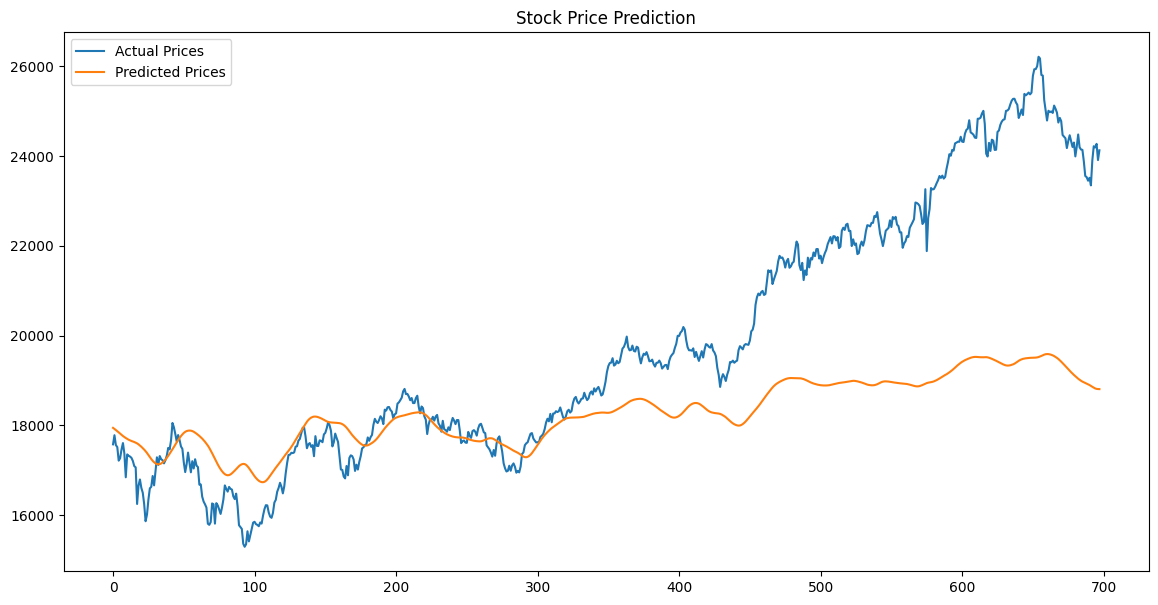

In [10]:
# Plot Results
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual, label='Actual Prices')
plt.plot(predictions, label='Predicted Prices')
plt.legend()
plt.title('Stock Price Prediction')
plt.show()

In [11]:
# Step 8: Save Model for Deployment
import joblib
joblib.dump(kmeans, 'kmeans_model.pkl')

for cluster_id, model in cluster_models.items():
    model.save(f'dsd_lstm_model_cluster_{cluster_id}.h5')